In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import wandb
from ff import FF, FFLayer, FFEncoder
from data import MergedDataset, FashionMNIST
from tqdm import tqdm


C:\Users\rdyt2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
batch_size_train = 512
batch_size_test = 512

In [4]:
# load fashion-mnist FASHIOn-MNIST
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./datasets/FashionMNIST', train=True, download=True,
                          transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(
                                (0.2860,), (0.3530,))
                            ])),
    batch_size=batch_size_train, shuffle=True)

train_loader_negative = torch.utils.data.DataLoader(MergedDataset(torchvision.datasets.FashionMNIST('./datasets/FashionMNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), 5, FashionMNIST.negative_data_generation), batch_size=batch_size_train, shuffle=True)    


In [5]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('./datasets/FashionMNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)
  

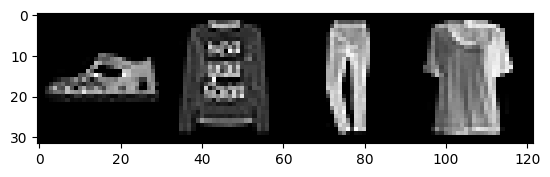

    5     2     1     0


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:4], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# print labels
print(' '.join('%5s' % labels[j].item() for j in range(4)))


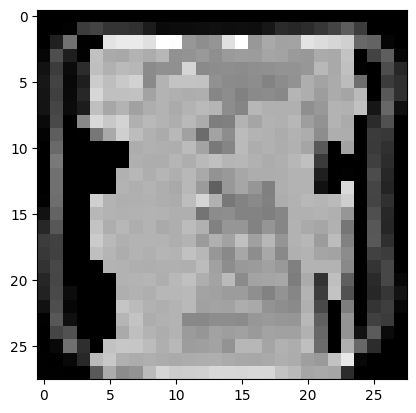

In [7]:
squared_error = lambda x: x.pow(2).mean(1)
deviation_error = lambda x: -((x - x.mean(1).unsqueeze(1)).pow(2).mean(1))
for i in enumerate(train_loader_negative):
    image = i[1].reshape((-1, 1, 28, 28))[0]
    # visualize image with pil
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt
    plt.imshow(image.reshape((28, 28)), cmap='gray')
    break;

In [8]:
threshold = 1.5
epochs_per_layer = 50
model = FF(logging=False, device=device)
optim_config = {
    "lr": 0.001,
}
positive_optim_config = {
    "lr": 0.001,

}
negative_optim_config = {
    "lr": 0.001,
}

goodness_function = squared_error
awake_period = 1
sleep_period = 1

model.add_layer(FFLayer(nn.Linear(784, 500).to(device), optimizer=torch.optim.Adam, epochs=epochs_per_layer, threshold=threshold, activation=nn.ReLU(), optim_config=optim_config, positive_optim_config=positive_optim_config, negative_optim_config=negative_optim_config, logging=False, name="layer 1", device = device, goodness_function=goodness_function).to(device))
model.add_layer(FFLayer(nn.Linear(500, 500).to(device), optimizer=torch.optim.Adam, epochs=epochs_per_layer, threshold=threshold, activation=nn.ReLU(), optim_config=optim_config, positive_optim_config=positive_optim_config, negative_optim_config=negative_optim_config, logging=False, name="layer 2", device = device, goodness_function=goodness_function).to(device))
model.add_layer(FFLayer(nn.Linear(500, 500).to(device), optimizer=torch.optim.Adam, epochs=epochs_per_layer, threshold=threshold, activation=nn.ReLU(), optim_config=optim_config, positive_optim_config=positive_optim_config, negative_optim_config=negative_optim_config, logging=False, name="layer 3", device = device, goodness_function=goodness_function).to(device))

In [9]:
wandb.init(project="FashionMNIST", entity="ffalgo", name="1-awake-1-sleep-0.001-0.001")
wandb.config = {
  "learning_rate": 0.01,
  "awake_period": awake_period,
  "sleep_period": sleep_period,
  "epochs_per_layer": epochs_per_layer,
  "batch_size": 512,
  "activation": "relu",
  "positive_lr": 0.001,
  "negative_lr": 0.0001,
  "threshold": threshold,
  "optimizer": torch.optim.Adam,
  "device": device
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rd211 (ffalgo). Use `wandb login --relogin` to force relogin


In [10]:
model = model.to(device)
epochs = 500
best_acc = 0.0
hour = 0
def get_random_number_besides(x):
    import random
    num = random.randint(0,9)
    if num==x: return get_random_number_besides(x)
    return num
def get_negative_y(y):
    return torch.tensor([get_random_number_besides(i) for i in y], dtype = torch.long).to(device)

for i in tqdm(range(epochs)):
    if i % 4 == 1:
        predictions, real = FashionMNIST.predict(test_loader, model, device)
        acc = np.sum(predictions == real)/len(real)
        wandb.log({"Accuracy on test data": acc})
        if acc > best_acc and acc > 0.8:
            best_acc = acc
            # torch.save(model.state_dict(), 'best_mnist_80%.ph')
        
    predictions, real = FashionMNIST.predict(train_loader, model, device)
    acc = np.sum(predictions == real)/len(real)
    wandb.log({"Accuracy on train data": acc})
    model.train()
    for a, b in zip(enumerate(train_loader), enumerate(train_loader_negative)):
        x_pos = a[1][0].to(device)
        y = a[1][1].to(device)
        x_pos,_ = FashionMNIST.overlay_y_on_x(x_pos, y)
        x_neg,_ = FashionMNIST.overlay_y_on_x(b[1].to(device), y)
        if hour % (awake_period + sleep_period) < awake_period:
            model.forward_positive(x_pos)
        else:
            model.forward_negative(x_neg)
        # model.forward(x_pos, x_neg)
        
        hour += 1

        
wandb.finish()

  3%|▎         | 16/500 [19:23<9:33:00, 71.03s/it]